# Using Bayesian inference to pick Coffee Shops

I like going to coffee shops in Edinburgh. I have opinions of them: some are better for meeting a friend and others are totally not laptop-friendly.

| | | |
|-|-|-|
| ![](images/2018-05-27-spoon.png) | ![](images/2018-05-27-twelve-triangles.png) |  ![](images/2018-05-27-cairngorm.png) | 


In this post, I prototype a way to use my opinions to rank coffee shops using a really simple probabilistic model. 

![](images/2018-05-27-ranking.png)


### Ranking based on Comparisons

Since ranking 20+ coffee shops is not that much fun, I'll gather data as comparisons of pairs of coffee shops. For example, I'll tell my system that I think BrewLab is a lot more laptop-friendly than Wellington Coffee, but that BrewLab and Levels are equally laptop-friendly. Then I'll figure out which are the best and worst coffee shops for laptops using probabilistic modelling.

Using pairs is convenient because it means I can borrow from approaches that rank players based on matches, like  [this `pymc3` demo](https://docs.pymc.io/notebooks/rugby_analytics.html) or [Microsoft's post on TrueSkill](https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/). (We also had a homework assignment on the math of this problem.)

### Coffee shops

Very important is what I mean by the attributes for coffee shops. For now, I'm using four metrics defined below in `METRIC_LIST`. They are

 - **reading**: Chill and reading a book
 - **laptop**: Camp out and doing work on my laptop
 - **meet**: Meet up with someone
 - **group**: Grab a table and hang out with folks 

These metrics are completely independent. It's more like four copies of the same problem with data stored in one place.

In [1]:
import os
import json

from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import yaml

/Users/jessica/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# helper functions you can skip over :D
def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

## Part 1: Data

### Metadata

When I go into `pymc3` land, the data will end up in a big matrix. I'd like a way to associate indexes with static information about the coffee shop, like its name and location. This will come in handy later when I want to label plots or build an app.

I really like using [YAML](http://yaml.org) for human-entered, computer-readable data. I entered a list of metadata about the coffee places I've visited in `data/coffee_metadata.yaml`. The `id` field is a human-readable unique identifier.

    - name: BrewLab
      id: brewlab
      location: university
    
    - name: Cult Espresso
      id: cult
      location: university

I also like using `namedtuples` to enforce schemas and catch typos when loading `yaml` or `json` files. I'll define a namedtuple `Metadata` for the above data and load the file. 

Then I'll make some useful data structures to map back and forth from id to index. The index in the data matrix will just be the position of the metadata dictionary in the `data/coffee_metadata.yaml` list. 

(I'm assuming `id` is unique and it won't ever change. When I save data, I'll associate data with a coffee shop by using it's `id`, not it's location in the matrix. I chose having a unique `id` field over using the index in the matrix because it's human-readable, which makes it easier to update incorrect comparisons, and it makes it trivial to add new coffee shops without changing matrix sizes.)

In [3]:
Metadata = namedtuple('Metadata', ['name', 'id', 'location'])

with open('data/coffee_metadata.yaml') as f:
    raw_data = yaml.load(f)
    
metadata = [Metadata(**place) for place in raw_data]

# this will be useful for converting an index into the id and back
index_to_id = [d.id for d in metadata]
ids_set = set(index_to_id)
id_to_index = {name: i for i, name in enumerate(index_to_id)}
num_items = len(index_to_id)

# check ids are unique
assert len(index_to_id) == len(ids_set), 'duplicate id! {}'.format(
    set(x for x in index_to_id if index_to_id.count(x) > 1)  # thanks https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
)

### Loading comparisons

I like to store data that humans shouldn't need to mess with in a file with lines of `json`. Worst-case, I can go in and delete or change a value, but I don't need to think about weird key orders that writing `yaml` has.

A file showing two comparisons would look like this:

    {"metric": "meet", "first": "artisan_broughton", "last": "cairngorm_george", "weight": 0.5}
    {"metric": "meet", "first": "wellington", "last": "twelve_triangles_portobello", "weight": 0.5}
    
Here's the idea: `metric` is which metric I'm trying to measure. In this case, `meeting` means where I like to meet up with someone. `first` and `last` are the two `id`s that should be in the big list of coffee shop `metadata` defined above. `weight` is how much better `first` is than `last`. It could be negative if I really want.

In [4]:
METRIC_LIST = ['meet', 'group', 'laptop', 'reading']
COMPARISON_FILE = 'data/coffee_comparisons.json'

Comparison = namedtuple('Comparison', ['metric', 'first', 'last', 'weight'])

metric_set = set(METRIC_LIST)

def load_comparisons():
    if os.path.isfile(COMPARISON_FILE):
        with open(COMPARISON_FILE) as f:
            all_comparisons = [
                Comparison(**json.loads(line))
                for line in f
            ]
        
        # make sure all metrics are legal!
        for c in all_comparisons:
            assert c.metric in metric_set, 'metric `{}` not in {}'.format(c.metric, metric_set)
            assert c.first in ids_set,  'id `{}` not in {}'.format(c.first, ids_set)
            assert c.last in ids_set,  'id `{}` not in {}'.format(c.last, ids_set)            
            
        print('Loaded {} comparisons'.format(len(all_comparisons)))
    else:
        print("No comparision data yet. No worries, I'll create one in a second.")
        all_comparisons = []
    return all_comparisons

all_comparisons = load_comparisons()

Loaded 72 comparisons


### Initial comparisons

If I have no data so far, I can begin by requesting a few comparisons between two randomly selected coffee shops.

The code will show me a `metric` name, and the first coffee shop id and second coffee shop id. Then I'll type in a number between 1 and 5. Here's what the keys mean:

 - `1`: totally the first coffee shop
 - `2`: lean towards the first coffee shop
 - `3`: draw
 - `4`: lean towards the second coffee shop
 - `5`: totally the second coffee shop

In [5]:
def keypress_to_entry_comparison(keypress, id1, id2):
    '''Convert according to the following requirement.
    
       "1": 1.0 for id1
       "2": 0.5 for id1
       "3": 0.0 (a draw!)
       "4": 0.5 for id2
       "5": 1.0 for id2
    
    '''
    keypress = int(keypress)

    if keypress < 1 or keypress > 5:
        raise Exception("bad key!")
    
    data = {
        'weight': (3 - keypress) / 2,
        'first': id1,
        'last': id2,
    }
    
    # swap if negative
    if data['weight'] < 0:
        tmp = data['first']
        data['first'] = data['second']
        data['second'] = tmp

    return data

In [6]:
# The plan is to select two random `id`s. This block defines some reasons why
# we shouldn't bother asking about the pairs.

def already_have_comparison(matches, metric, a, b):
    '''Returns true if ids `id1` and `id2` already have been compared for this stat'''    
    all_comparison_pairs = set((c.first, c.last) for c in all_comparisons if c.metric == metric)
    return (a, b) in all_comparison_pairs or (b, a) in all_comparison_pairs

def is_comparison_to_self(id1, id2):
    '''Returns true if `id1` and `id2` are the same'''
    return id1 == id2

### Inputting comparisons

This part gets nostalgic. A lot of my first programs were about asking for data from the user. Over time I've moved to different approaches, like the YAML file above, but I think this way works better because the computer is choosing which items to show me. As an example session:

    laptop 1) lowdown 5) wellington? 1
    laptop 1) black_medicine 5) levels? 4
    laptop 1) artisan_stockbridge 5) castello? q
    
I can type `q` to exit. Otherwise, I'll be asked to compare two coffee shops and should type a number between 1 and 5.

(If you want to run this, set `SHOULD_ASK = True`. I turn it off by default so I can run the entire notebook without being asked for input.)

In [7]:
# Change this to True to start answering questions!
# It's False by default so you can run the full notebook
SHOULD_ASK = False

# Update METRICS_TO_CHECK with the list of attributes this should ask about
METRICS_TO_CHECK = METRIC_LIST

# Note! I'm using a for-loop here so it doesn't continue forever if it can't
# find anymore matches. Normally, I'm planning to press `q` to quit.
MAX_CHECK = 100 if SHOULD_ASK else 0


for _ in range(MAX_CHECK):
    # Eh, reload the comparisons so I don't ask for duplicates in this session
    
    # Choose a random stat
    metric = np.random.choice(METRICS_TO_CHECK)
    
    # Choose two random ids
    id1, id2 = np.random.choice(index_to_id, size=2, replace=False)
    
    if is_comparison_to_self(id1, id2):
        print('Duplicate!')
        continue
    
    if already_have_comparison(all_comparisons, metric, id1, id2):
        print('Already have comparison of {} and {} for {}'.format(id1, id2, metric))
        continue
    
    keyboard_input = input('{} 1) {} 5) {}? '.format(metric, id1, id2))

    if keyboard_input == 'q':
        break

    entry_comparison = keypress_to_entry_comparison(keyboard_input, id1, id2)
    # modify entry_comparison to add stats to the entry comparison.
    entry_comparison['metric'] = metric

    # now append to the comparison file!
    with open(COMPARISON_FILE, 'a') as f:
        f.write(json.dumps(entry_comparison))
        f.write('\n')

### Aside: exploring comparisions data

I can check what comparisons I have data for. Since the comparison is symmetric, I'll mark sides of the matrix.

In [8]:
all_comparisons = load_comparisons()

matches = {
    k: np.zeros((num_items, num_items))
    for k in METRIC_LIST
}

for c in all_comparisons:
    # only use the most recent weight.
    matches[c.metric][id_to_index[c.first], id_to_index[c.last]] = c.weight
    matches[c.metric][id_to_index[c.last], id_to_index[c.first]] = -c.weight

Loaded 72 comparisons


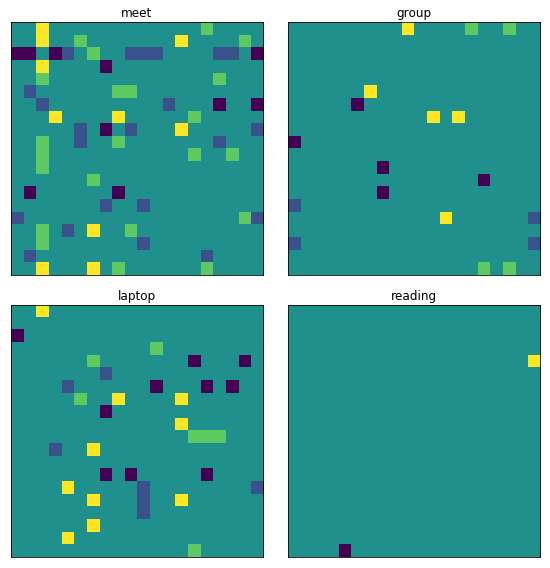

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for ax, (k, v) in zip(axs, matches.items()):
    ax.imshow(v)
    ax.set_title(k)
    hide_ticks(ax)
plt.tight_layout()
maybe_save_plot('2018-05-27-pairwise-comparison')
plt.show()

I can also show a plot of the weights. This shows how my data is a little odd: I only ever store positive numbers, and they're rarely 0. I'm going to ignore it in this post, but I think it's something my non-prototype model should take into account.

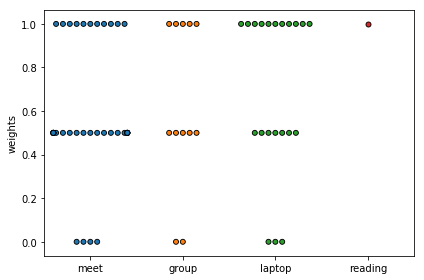

In [10]:
# sorry i'm doing this four times
all_ratings = [
    [
        c.weight
        for c in all_comparisons
        if c.metric == metric
    ]
    for metric in METRIC_LIST
]

plt.ylabel("weights")
sns.swarmplot(data=all_ratings, edgecolor="black", linewidth=.9)
plt.xticks(plt.xticks()[0], METRIC_LIST)
maybe_save_plot('2018-05-27-comparisons-box')
pass

## Part 2: Modelling

For the rest of this notebook, I'll limit the scope to a single metric by setting `METRIC_NAME = laptop`. To explore other metrics, I can update that string and rerun the following cells.

### Model

Using the `laptop` metric as an example, my model says there is some unknown `laptop` metric for each coffee shop. This is what I'm trying to learn. The metric is Gaussian distributed around some mean. Given enough data, it should approach the actual laptop-friendliness of the coffee shop. 

When I said that BrewLab was better for laptop work than Wellington Coffee, my model takes that to mean that BrewLab's `laptop` metric is probably higher than Wellington's. Specifically, the number between 0 and 1 that I gave it is the difference between BrewLab's mean and Wellington's mean.

When I make a comparison, I might be a little off and the weights might be noisy. Maybe I'm more enthusiastic about Cairngorm over Press because I haven't been to Press recently. `pymc3` can take that into account too! I'll say my comparison weight is also Gaussian distributed.

I'm basing my code on [this tutorial](https://docs.pymc.io/notebooks/rugby_analytics.html) but with the above model. Like the rugby model, I also use one shared `HalfStudentT` variable for the metric's standard deviations.
For each comparison, I compute the difference between the "true_metric" for the first and second coffee shop, and say that should be around the score I actually gave it. 

### Warning

Because the model is probably making terrible assumptions that I can't recognize yet, I'm mostly using this model to see how a `pymc3` model could fit into this project. I can always go back and improve the model!

In [11]:
METRIC_NAME = 'laptop'

all_comparisons = load_comparisons()


FIRST = 0
LAST = 1
comparison_matrix = np.vstack(
    (id_to_index[c.first], id_to_index[c.last])
    for c in all_comparisons
    if c.metric == METRIC_NAME
)

weight_vector = np.vstack(
    c.weight
    for c in all_comparisons
    if c.metric == METRIC_NAME
)

print('using {} observations for {}'.format(weight_vector.shape[0], METRIC_NAME))

model = pm.Model()

with model:
    metric_sd = pm.HalfStudentT('metric_sd', nu=1, sd=3)
    
    true_metric = pm.Normal(METRIC_NAME, mu=0, sd=metric_sd, shape=num_items)

    comparison = pm.Deterministic(
        'comparison', (
            true_metric[comparison_matrix[:, FIRST]] - true_metric[comparison_matrix[:, LAST]]
        )
    )
    
    obs = pm.StudentT('obs', nu=7, mu=comparison, sd=0.25, observed=weight_vector)
    
    trace = pm.sample(500, tune=1000, cores=3)

Loaded 72 comparisons
using 21 observations for laptop


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [laptop, metric_sd_log__]
100%|██████████| 1500/1500 [00:08<00:00, 175.46it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '32225' (I am process '32226')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jessica/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '32123' (I am process '32226')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jessica/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir
The number of effective samples is smaller than 25% for some parameters.


`pymc3` gives a lot of tools to check how well sampling went. I'm still learning how they work, but nothing jumps out yet. 

 - The sampler gave that the number of effective samples is small, but [they](https://discourse.pymc.io/t/the-number-of-effective-samples-is-smaller-than-25-for-some-parameters/1050) say that's probably okay.
 - Below I plot the `traceplot`. I told it to sample with 3 chains. There are three copies of each distribution which are all in roughly the same place.

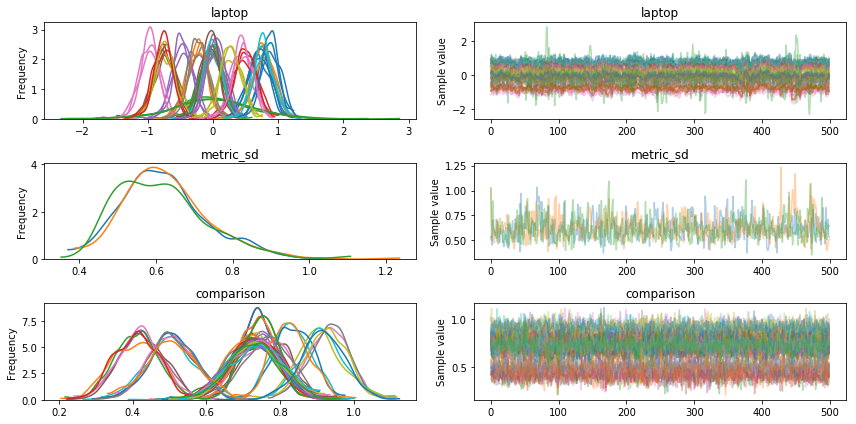

In [12]:
pm.traceplot(trace)
maybe_save_plot('2018-05-27-traceplot')
plt.show()

## Plotting

*Watch out:* Now that I need to interpret the results, I'm at high risk of making embarrassing assumptions that I will use in the future as a "don't do it this way" :D

Like [this tutorial](https://docs.pymc.io/notebooks/rugby_analytics.html), I'll plot the medians from the samples and use the Highest Posterior Density (HPD) as credible intervals. HPD finds the smallest range of the posterior distribution that contains 95% of its mass.

This looks really cool!

In [13]:
# code for plots

def plot_hpd(trace, field_name, unsorted_labels):
    unsorted_medians = pm.stats.quantiles(trace[field_name])[50]
    unsorted_err = np.abs(pm.stats.hpd(trace[field_name]).T - unsorted_medians)
    
    sorted_indices = np.argsort(unsorted_medians)
    
    median = unsorted_medians[sorted_indices]
    err = unsorted_err[:, sorted_indices]
    labels = unsorted_labels[sorted_indices]
    
    fig = plt.figure(figsize=(6, 6))
    plt.errorbar(median, range(len(median)), xerr=err, fmt='o', label=field_name)
    
    for i, label in enumerate(labels):
        plt.text(np.min(median - err[0]) * 1.1, i, s=label, horizontalalignment='right', verticalalignment='center')
    
    plt.title('{}'.format(field_name))
    
    plt.axis('off')
    
    return sorted_indices

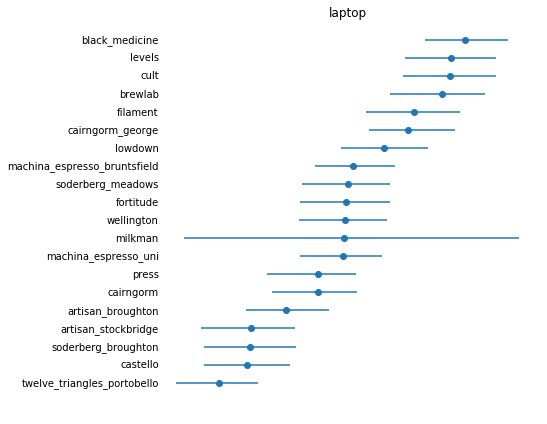

In [14]:
plot_hpd(trace, METRIC_NAME, np.array(index_to_id))
maybe_save_plot('2018-05-27-ranking')
pass

I think I can take two coffee shops and ask in how many posterior samples one better than the other. When the model doesn't have much opinion, it's close to 0.5. Otherwise it's closer to 1 or 0.

In [15]:
def plot_posterior(ax, trace, metric, coffee_id):
    sns.kdeplot(trace[metric][:, id_to_index[coffee_id]], shade=True, label=coffee_id, ax=ax)

def compare_two(trace, metric, a, b): 
    results_a = trace[metric][:, id_to_index[a]]
    results_b = trace[metric][:, id_to_index[b]]
    return (results_a > results_b).mean()

pairs = [
    ('milkman', 'castello'),
    ('brewlab', 'levels'), 
    ('levels', 'castello'),        
]

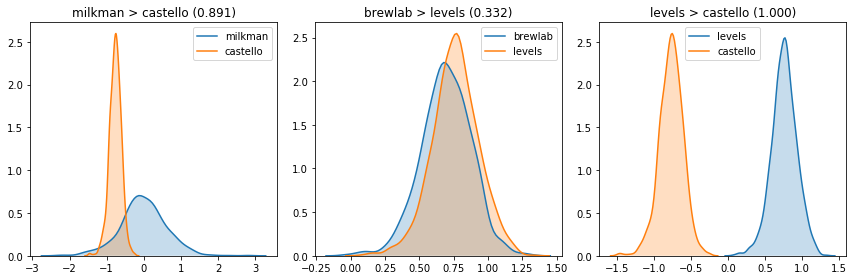

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))

for ((a, b), ax) in zip(pairs, axs):
    plot_posterior(ax, trace, METRIC_NAME, a)
    plot_posterior(ax, trace, METRIC_NAME, b)
    ax.set_title('{} > {} ({:0.3f})'.format(a, b, compare_two(trace, METRIC_NAME, a, b)))
maybe_save_plot('2018-05-27-posteriors')    
plt.show()

### Comparing model results to actual results

This is another step I can take in checking that the model seems reasonable is to ask what it predicts for each observation should be and plot it. This is asking if the model can predict the data it learned from.

It does miss two values. It's a little suspicious. It seems like it tends to have trouble predicting that a comparison could be weighted as 0.

100%|██████████| 500/500 [00:00<00:00, 2786.01it/s]


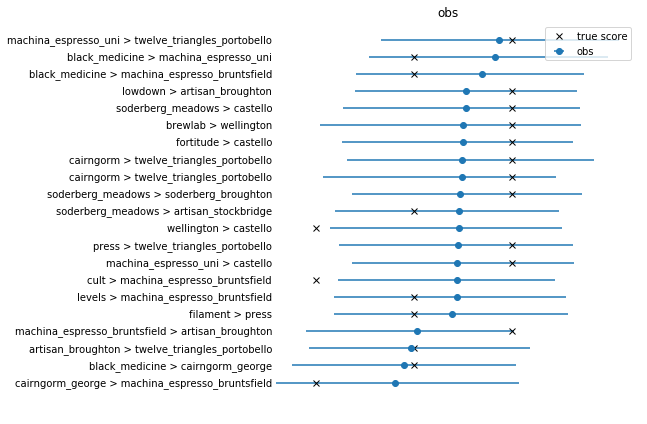

In [17]:
labels = np.array([
    '{} > {}'.format(c.first, c.last, c.weight)
    for c in all_comparisons
    if c.metric == METRIC_NAME
])

with model:
    ppc = pm.sample_ppc(trace, samples=500, model=model)

sorted_indexes = plot_hpd(ppc, 'obs', labels)
plt.plot(weight_vector[sorted_indexes], range(len(labels)), 'xk', label='true score')
plt.legend()
maybe_save_plot('2018-05-27-predictions')
plt.show()

## Part 3: Batched active learning

I can use my attempts at quantifying uncertainty as a heuristic for choosing which questions to ask. I do this using `is_pretty_certain`. This is super cool! If the model is totally sure that Artisan is better for reading than Castello, it doesn't ask about it.

Like before, update `SHOULD_ASK` if you want to try it out.

### Ways to make this even cooler

The thing is that I'll just train the model from scratch with this new data.
In some special models like [TrueSkill](https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/), you can update the uncertainty in closed-form.

If this was a real product, there might be enough random questions to ask that it's fine to not always ask the most-useful question. If it's time-consuming to answer the question, it might be worth learning the model in between, using a different model that's easy to update with new information, or finding some middle ground.

In [18]:
def is_pretty_certain(trace, metric, a, b):
    '''If the posteriors probably don't overlap much, we are pretty certain one of
    them will win
    '''
    hpd = pm.stats.hpd(trace[metric])
    
    a_low, a_high = hpd[id_to_index[a]]
    b_low, b_high = hpd[id_to_index[b]]
    return (a_low > b_high or b_low > a_high)

In [19]:
# Change this to True to start answering questions!
# It's False by default so you can run the full notebook
SHOULD_ASK = False

# Note! I'm using a for-loop here so it doesn't continue forever if it can't
# find anymore matches. Normally, I'm planning to press `q` to quit.
MAX_CHECK = 100 if SHOULD_ASK else 0

for _ in range(MAX_CHECK):
    # only ask about the active metric, since we only have the trace for this metric.
    metric = METRIC_NAME
    
    # Choose two random ids
    id1, id2 = np.random.choice(index_to_id, size=2, replace=False)
    
    if is_comparison_to_self(id1, id2):
        print('Duplicate!')
        continue
    
    if already_have_comparison(all_comparisons, metric, id1, id2):
        print('Already have match between {} {}'.format(id1, id2))
        continue
    
    if is_pretty_certain(trace, metric, id1, id2):
        print('Pretty sure about {} {}'.format(id1, id2))
        continue
    
    keyboard_input = input('{} 1) {} 5) {}? '.format(metric, id1, id2))

    if keyboard_input == 'q':
        break

    entry_comparison = keypress_to_entry_comparison(keyboard_input, id1, id2)
    # modify entry_comparison to add stats to the entry comparison.
    entry_comparison['metric'] = metric

    # now append to the comparison file!
    with open(COMPARISON_FILE, 'a') as f:
        f.write(json.dumps(entry_comparison))
        f.write('\n')

## Conclusion

This was a fun first try! It took me an afternoon to put together, it looks like it's roughly doing what I want, and it's cool knowing that it's backed by a probabilistic model. 

It's also cool because the application is general for other things I'd want to rank, like books. I just need to update filenames, drop in other things into a YAML file, and update the list of attributes. 

I started experimenting with some of `pymc3`'s neat tools like `sample_ppc` and `plot_posterior`.

### More blog material

This project also helped me see how much more I need to learn about `pymc3` and Bayesian data analysis. 

The model seems to make reasonable predictions and adjust to data like I'd expect. The embarrassing thing is every time I tried to adjust the model, I would start getting terrible results and not know why. It's useful to have data and a model I can play with, but I have a lot to learn! 